# TrainingTransferMulti
Entrainement des modèles de transfer learning DenseNet201 13 bandes pour café contre reste et culture contre non-culture

* Romain Capocasale
* IADeforestation
* HES-SO MASTER

# Import

In [1]:
import os
import random
import numpy as np
import rasterio
import matplotlib.pyplot as plt 
import pandas as pd
import statistics
import seaborn as sn
import json
import geopandas as gpd
import spacv

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, classification_report

from tensorflow.python.client import device_lib
from tensorflow.keras.models import Model, load_model, model_from_json
from tensorflow.keras.applications.densenet import DenseNet201 as DenseNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from focal_loss import BinaryFocalLoss
from keras import backend as K 
from shapely import wkt

from IAdeforestation.preprocessing import *
from IAdeforestation.training import *
from IAdeforestation.tools import *
from IAdeforestation.spatial_cross_val import * 
from IAdeforestation.evaluation import *

/home/romain.capocasa/romain_env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
print(device_lib.list_local_devices())

K.clear_session()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15990162008013649839
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7783953216
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7787268452372559365
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
SAVED_MODELS_PATH = os.path.join('saved_models', 'transfer_learning')
SAVED_DATASET_PATH = "datasets"
vietnam = gpd.read_file(os.path.join("district","diaphanhuyen.shp"))

# Load base model

In [6]:
source_model = load_model("transfer_learning_model/dense_ms_from_scratch.209-0.990.hdf5", compile=False)
source_model.trainable = False

### Uncomment above line for 32x32 images

In [7]:
#source_model = change_model(source_model, new_input_shape=(None, 32,32,13),custom_objects={'LeakyReLU':LeakyReLU})

In [8]:
source_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 13)] 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 70, 70, 13)   0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   40768       zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [9]:
def create_model():
    # Add new layer to pre-trained network
    flat1 = Flatten()(source_model.layers[-3].output)
    dropout_flatten = Dropout(0.5)(flat1)

    dense256 = Dense(128, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(0.001))(dropout_flatten)
    dropout256 = Dropout(0.5)(dense256)

    dense32 = Dense(32, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(0.001))(dropout256)
    dropout32 = Dropout(0.5)(dense32)

    output = Dense(1, activation='sigmoid')(dropout32)

    return Model(inputs=source_model.input, outputs=output)

# Coffee vs other
## Spatial Cross val

In [10]:
train_data = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'coffee_10fold', 'train_data.csv')))
train_data['geometry'] = train_data['geometry'].apply(wkt.loads)

### Compute class weight

In [11]:
nb_0 = len(train_data[train_data['label']==0])
nb_1 = len(train_data[train_data['label']==1])
total = nb_0 + nb_1

weight_for_0 = (1 / nb_0)*(total)/2.0 
weight_for_1 = (1 / nb_1)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [12]:
nb_labels = train_data['label'].value_counts().to_dict()
prop0 = nb_labels[0]/(nb_labels[0]+nb_labels[1])
prop1 = nb_labels[1]/(nb_labels[0]+nb_labels[1])

print(prop0)
print(prop1)

0.2469879518072289
0.7530120481927711


### Train model

In [18]:
# Params
BATCH_SIZE = 64
EPOCH = 100
LEARNING_RATE = 0.00001
DATA_AUGMENTATION_MULTIPLIATOR = 3
RUN_NAME = 'final_spacv_10FOLD_coffee_2'

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME))
    
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      f1_score_keras
]

results = []

In [ ]:
NB_FOLD = 5
for i_fold in range(0, NB_FOLD):
    geo_train = gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","coffee_10fold",f"train_{i_fold+1}_data.csv")))
    geo_train['geometry'] = geo_train['geometry'].apply(wkt.loads)
    
    geo_val = gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","coffee_10fold",f"val_{i_fold+1}_data.csv")))
    geo_val['geometry'] = geo_val['geometry'].apply(wkt.loads)

    display_cross_val_map_class(geo_train, geo_val, vietnam, f"Cross validation split fold : {i_fold+1}")
    
    print(f"Fold {i_fold+1} Number coffee - train : {len(geo_train[geo_train['label'] == 0])}")
    print(f"Fold {i_fold+1} Number no-coffee - train : {len(geo_train[geo_train['label'] == 1])}")

    print(f"Fold {i_fold+1} Number coffee - val : {len(geo_val[geo_val['label'] == 0 ])}")
    print(f"Fold {i_fold+1} Number no-coffee - val : {len(geo_val[geo_val['label'] == 1])}")
    print(f"Training for fold {i_fold+1}")

    print("-----")
    
    train_generator = generator(geo_train['path'].to_numpy(), 
                                  geo_train['label'].to_numpy(), 
                                  eurosat_params['mean'], 
                                  eurosat_params['std'], 
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = generator(geo_val['path'].to_numpy(), 
                                geo_val['label'].to_numpy(), 
                                eurosat_params['mean'], 
                                eurosat_params['std'], 
                                batch_size=BATCH_SIZE)


    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
      
    model = create_model()

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)

    history = model.fit(train_generator,
                        epochs=EPOCH,
                        steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=validation_generator,
                        validation_steps=(len(geo_val)//BATCH_SIZE),
                        callbacks=[earlystopper],
                        class_weight=class_weight)

    model.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(i_fold) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(i_fold) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    results.append(result)

    print(f"Fold {i_fold+1} loss : {result[0]}")
    print(f"Fold {i_fold+1} accuracy : {result[1]}")
    print(f"Fold {i_fold+1} F1-score : {result[4]}")
    
    compute_score(geo_val, model)

    print("\n")

    K.clear_session()

In [17]:
with open(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

### Fold score

In [18]:
losses, accs, precisions, recalls, f1_scores = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")
print("\n")
print(f"Mean F1-Score : {np.mean(f1_scores)}")
print(f"Stdev F1-Score : {np.std(f1_scores)}")

Mean accuracy : 0.825
Stdev accuracy : 0.038858844110768405


Mean loss : 0.506082421541214
Stdev loss : 0.06169488937446249


Mean precision : 0.5778481662273407
Stdev precision : 0.06843379003237458


Mean recall : 0.9107117176055908
Stdev recall : 0.048704962982829565


Mean F1-Score : 0.7033987439636167
Stdev F1-Score : 0.047403598248279326


### Loss and accuracy plots per fold

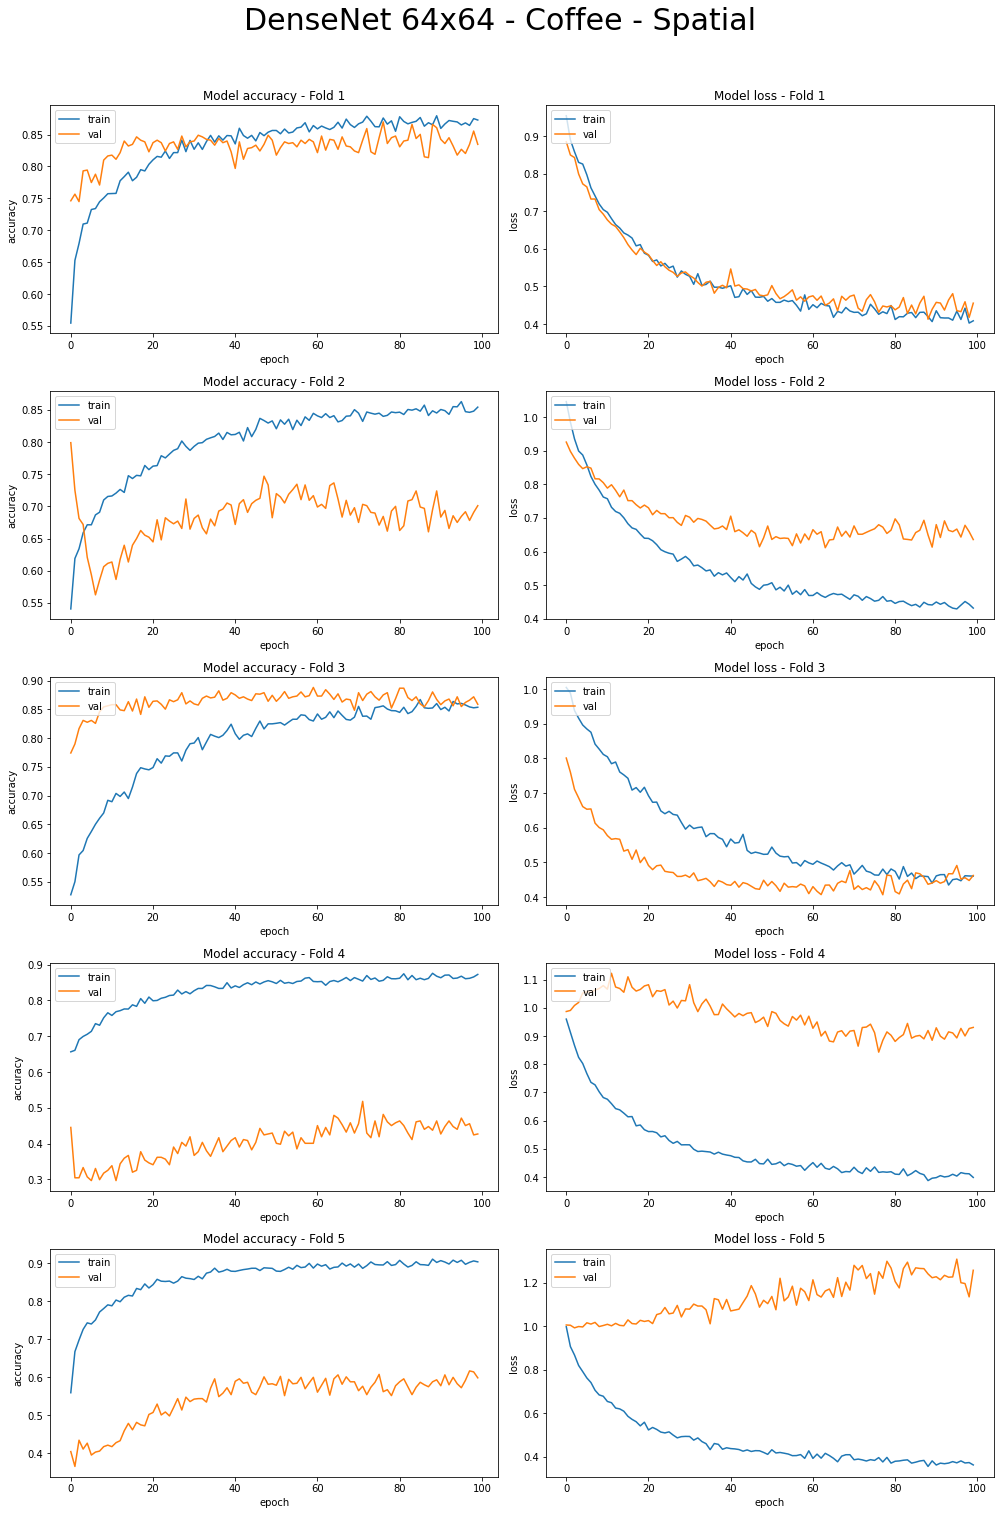

In [5]:
path = os.path.join(SAVED_MODELS_PATH, 'Coffee', 'final_spacv_10FOLD_coffee_2')
plot_acc_loss(path, "DenseNet 64x64 - Coffee - Spatial")

## Stratified cross-val

In [11]:
data_train = gpd.GeoDataFrame(pd.read_csv(os.path.join( 'datasets', 'strat_train.csv')))
data_train['geometry'] = data_train['geometry'].apply(wkt.loads)

### Compute class weight

In [12]:
nb_0 = len(data_train[data_train['label']==0])
nb_1 = len(data_train[data_train['label']==1])
total = nb_0 + nb_1

weight_for_0 = (1 / nb_0)*(total)/2.0 
weight_for_1 = (1 / nb_1)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 2.07035175879397, 1: 0.6592}

### Train model

In [15]:
# Params
BATCH_SIZE = 64
EPOCH = 100
LEARNING_RATE = 0.00001
DATA_AUGMENTATION_MULTIPLIATOR = 3
RUN_NAME = 'strat_coffee_2'
NB_FOLD = 5

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME))
    
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall')
]

In [16]:
fold_index = 0

results = []

skf = StratifiedKFold(n_splits=5)
for train, validation in skf.split(data_train['path'].to_numpy(), data_train['label'].to_numpy()):
    
    geo_train = data_train.iloc[train]
    geo_val = data_train.iloc[validation]
    
    train_generator = generator(geo_train['path'].to_numpy(), 
                                  geo_train['label'].to_numpy(), 
                                  eurosat_params['mean'], 
                                  eurosat_params['std'], 
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = generator(geo_val['path'].to_numpy(), 
                                geo_val['label'].to_numpy(), 
                                eurosat_params['mean'], 
                                eurosat_params['std'], 
                                batch_size=BATCH_SIZE)


    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
      
    model = create_model()

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=LEARNING_RATE), metrics=METRICS)

    history = model.fit(train_generator,
                                epochs=EPOCH,
                                steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                                validation_data=validation_generator,
                                validation_steps=len(geo_val)//BATCH_SIZE,
                                callbacks=[earlystopper])

    model.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    result.append(2*((result[2]*result[3])/(result[2]+result[3])))
    results.append(result)
    
    print(f"Fold {fold_index} loss : {result[0]}")
    print(f"Fold {fold_index} accuracy : {result[1]}")
    print(f"Fold {fold_index} F1-score : {result[4]}")
    print("\n")

    K.clear_session()

    fold_index+=1
    

Epoch 1/100
60/60 [==============================] - 18s 167ms/step - loss: 1.0745 - accuracy: 0.4657 - precision: 0.8078 - recall: 0.4026 - val_loss: 0.8809 - val_accuracy: 0.7625 - val_precision: 0.7774 - val_recall: 0.9718
Epoch 2/100
60/60 [==============================] - 8s 129ms/step - loss: 0.9192 - accuracy: 0.6222 - precision: 0.7678 - recall: 0.7110 - val_loss: 0.7980 - val_accuracy: 0.7688 - val_precision: 0.7688 - val_recall: 1.0000
Epoch 3/100
60/60 [==============================] - 8s 130ms/step - loss: 0.8610 - accuracy: 0.7016 - precision: 0.7681 - recall: 0.8648 - val_loss: 0.8076 - val_accuracy: 0.7125 - val_precision: 0.7147 - val_recall: 0.9956
Epoch 4/100
60/60 [==============================] - 8s 130ms/step - loss: 0.8110 - accuracy: 0.7431 - precision: 0.7815 - recall: 0.9188 - val_loss: 0.7773 - val_accuracy: 0.7219 - val_precision: 0.7210 - val_recall: 1.0000
Epoch 5/100
60/60 [==============================] - 8s 129ms/step - loss: 0.7709 - accuracy: 0.763

60/60 [==============================] - 8s 132ms/step - loss: 0.4357 - accuracy: 0.8653 - precision: 0.8833 - recall: 0.9481 - val_loss: 0.4674 - val_accuracy: 0.8313 - val_precision: 0.8697 - val_recall: 0.9190
Epoch 74/100
60/60 [==============================] - 8s 131ms/step - loss: 0.4370 - accuracy: 0.8570 - precision: 0.8711 - recall: 0.9492 - val_loss: 0.3905 - val_accuracy: 0.8938 - val_precision: 0.9231 - val_recall: 0.9449
Epoch 75/100
60/60 [==============================] - 8s 131ms/step - loss: 0.4342 - accuracy: 0.8579 - precision: 0.8818 - recall: 0.9406 - val_loss: 0.4495 - val_accuracy: 0.8375 - val_precision: 0.8599 - val_recall: 0.9325
Epoch 76/100
60/60 [==============================] - 8s 130ms/step - loss: 0.4385 - accuracy: 0.8659 - precision: 0.8840 - recall: 0.9486 - val_loss: 0.4303 - val_accuracy: 0.8656 - val_precision: 0.8939 - val_recall: 0.9402
Epoch 77/100
60/60 [==============================] - 8s 131ms/step - loss: 0.4389 - accuracy: 0.8563 - preci

60/60 [==============================] - 8s 131ms/step - loss: 0.4567 - accuracy: 0.8624 - precision: 0.8749 - recall: 0.9561 - val_loss: 0.4020 - val_accuracy: 0.8938 - val_precision: 0.9038 - val_recall: 0.9631
Epoch 66/100
60/60 [==============================] - 8s 130ms/step - loss: 0.4511 - accuracy: 0.8585 - precision: 0.8677 - recall: 0.9558 - val_loss: 0.4449 - val_accuracy: 0.8562 - val_precision: 0.8750 - val_recall: 0.9520
Epoch 67/100
60/60 [==============================] - 8s 132ms/step - loss: 0.4480 - accuracy: 0.8569 - precision: 0.8732 - recall: 0.9499 - val_loss: 0.4008 - val_accuracy: 0.8813 - val_precision: 0.8821 - val_recall: 0.9802
Epoch 68/100
60/60 [==============================] - 8s 131ms/step - loss: 0.4430 - accuracy: 0.8518 - precision: 0.8665 - recall: 0.9515 - val_loss: 0.4356 - val_accuracy: 0.8500 - val_precision: 0.8556 - val_recall: 0.9673
Epoch 69/100
60/60 [==============================] - 8s 131ms/step - loss: 0.4524 - accuracy: 0.8478 - preci

60/60 [==============================] - 8s 129ms/step - loss: 0.4935 - accuracy: 0.8466 - precision: 0.8616 - recall: 0.9511 - val_loss: 0.4408 - val_accuracy: 0.8719 - val_precision: 0.8782 - val_recall: 0.9675
Epoch 37/100
60/60 [==============================] - 8s 131ms/step - loss: 0.5069 - accuracy: 0.8464 - precision: 0.8711 - recall: 0.9369 - val_loss: 0.4529 - val_accuracy: 0.8625 - val_precision: 0.8717 - val_recall: 0.9585
Epoch 38/100
60/60 [==============================] - 8s 131ms/step - loss: 0.5019 - accuracy: 0.8383 - precision: 0.8556 - recall: 0.9466 - val_loss: 0.4307 - val_accuracy: 0.8906 - val_precision: 0.8893 - val_recall: 0.9842
Epoch 39/100
60/60 [==============================] - 8s 129ms/step - loss: 0.4833 - accuracy: 0.8465 - precision: 0.8630 - recall: 0.9504 - val_loss: 0.4149 - val_accuracy: 0.8969 - val_precision: 0.9102 - val_recall: 0.9588
Epoch 40/100
60/60 [==============================] - 8s 130ms/step - loss: 0.4987 - accuracy: 0.8271 - preci

60/60 [==============================] - 8s 127ms/step - loss: 0.7124 - accuracy: 0.7700 - precision: 0.7842 - recall: 0.9646 - val_loss: 0.7050 - val_accuracy: 0.7437 - val_precision: 0.7437 - val_recall: 1.0000
Epoch 8/100
60/60 [==============================] - 8s 131ms/step - loss: 0.7063 - accuracy: 0.7769 - precision: 0.7873 - recall: 0.9702 - val_loss: 0.6956 - val_accuracy: 0.7156 - val_precision: 0.7147 - val_recall: 1.0000
Epoch 9/100
60/60 [==============================] - 7s 126ms/step - loss: 0.6883 - accuracy: 0.7810 - precision: 0.7881 - recall: 0.9710 - val_loss: 0.6387 - val_accuracy: 0.7875 - val_precision: 0.7834 - val_recall: 1.0000
Epoch 10/100
60/60 [==============================] - 8s 127ms/step - loss: 0.6854 - accuracy: 0.7610 - precision: 0.7817 - recall: 0.9483 - val_loss: 0.6407 - val_accuracy: 0.7969 - val_precision: 0.7903 - val_recall: 1.0000
Epoch 11/100
60/60 [==============================] - 8s 128ms/step - loss: 0.6487 - accuracy: 0.7935 - precisi

60/60 [==============================] - 7s 126ms/step - loss: 0.4160 - accuracy: 0.8696 - precision: 0.8877 - recall: 0.9504 - val_loss: 0.4591 - val_accuracy: 0.8656 - val_precision: 0.8848 - val_recall: 0.9520
Epoch 80/100
60/60 [==============================] - 7s 126ms/step - loss: 0.4260 - accuracy: 0.8583 - precision: 0.8749 - recall: 0.9471 - val_loss: 0.4304 - val_accuracy: 0.8594 - val_precision: 0.8651 - val_recall: 0.9520
Epoch 81/100
60/60 [==============================] - 7s 126ms/step - loss: 0.4329 - accuracy: 0.8540 - precision: 0.8827 - recall: 0.9299 - val_loss: 0.4394 - val_accuracy: 0.8687 - val_precision: 0.8826 - val_recall: 0.9549
Epoch 82/100
60/60 [==============================] - 7s 126ms/step - loss: 0.4347 - accuracy: 0.8550 - precision: 0.8789 - recall: 0.9362 - val_loss: 0.4367 - val_accuracy: 0.8906 - val_precision: 0.8943 - val_recall: 0.9713
Epoch 83/100
60/60 [==============================] - 7s 126ms/step - loss: 0.4158 - accuracy: 0.8601 - preci

60/60 [==============================] - 8s 127ms/step - loss: 0.4847 - accuracy: 0.8430 - precision: 0.8528 - recall: 0.9543 - val_loss: 0.4358 - val_accuracy: 0.8813 - val_precision: 0.8873 - val_recall: 0.9721
Epoch 53/100
60/60 [==============================] - 7s 125ms/step - loss: 0.4746 - accuracy: 0.8512 - precision: 0.8613 - recall: 0.9550 - val_loss: 0.4753 - val_accuracy: 0.8406 - val_precision: 0.8534 - val_recall: 0.9498
Epoch 54/100
60/60 [==============================] - 8s 127ms/step - loss: 0.4687 - accuracy: 0.8495 - precision: 0.8659 - recall: 0.9489 - val_loss: 0.4643 - val_accuracy: 0.8531 - val_precision: 0.8507 - val_recall: 0.9702
Epoch 55/100
60/60 [==============================] - 8s 127ms/step - loss: 0.4742 - accuracy: 0.8471 - precision: 0.8682 - recall: 0.9412 - val_loss: 0.4081 - val_accuracy: 0.8687 - val_precision: 0.8723 - val_recall: 0.9715
Epoch 56/100
60/60 [==============================] - 7s 125ms/step - loss: 0.4547 - accuracy: 0.8590 - preci

In [19]:
with open(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

In [20]:
losses, accs, precisions, recalls, f1_scores = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")
print("\n")
print(f"Mean F1-Score : {np.mean(f1_scores)}")
print(f"Stdev F1-Score : {np.std(f1_scores)}")

Mean accuracy : 0.85859375
Stdev accuracy : 0.009043622580304864


Mean loss : 0.41293240189552305
Stdev loss : 0.027867288674426484


Mean precision : 0.8757479310035705
Stdev precision : 0.005627822229397637


Mean recall : 0.9458356380462647
Stdev recall : 0.012983210322106366


Mean F1-Score : 0.909388249922852
Stdev F1-Score : 0.006541125551406981


### Loss and accuracy per fold

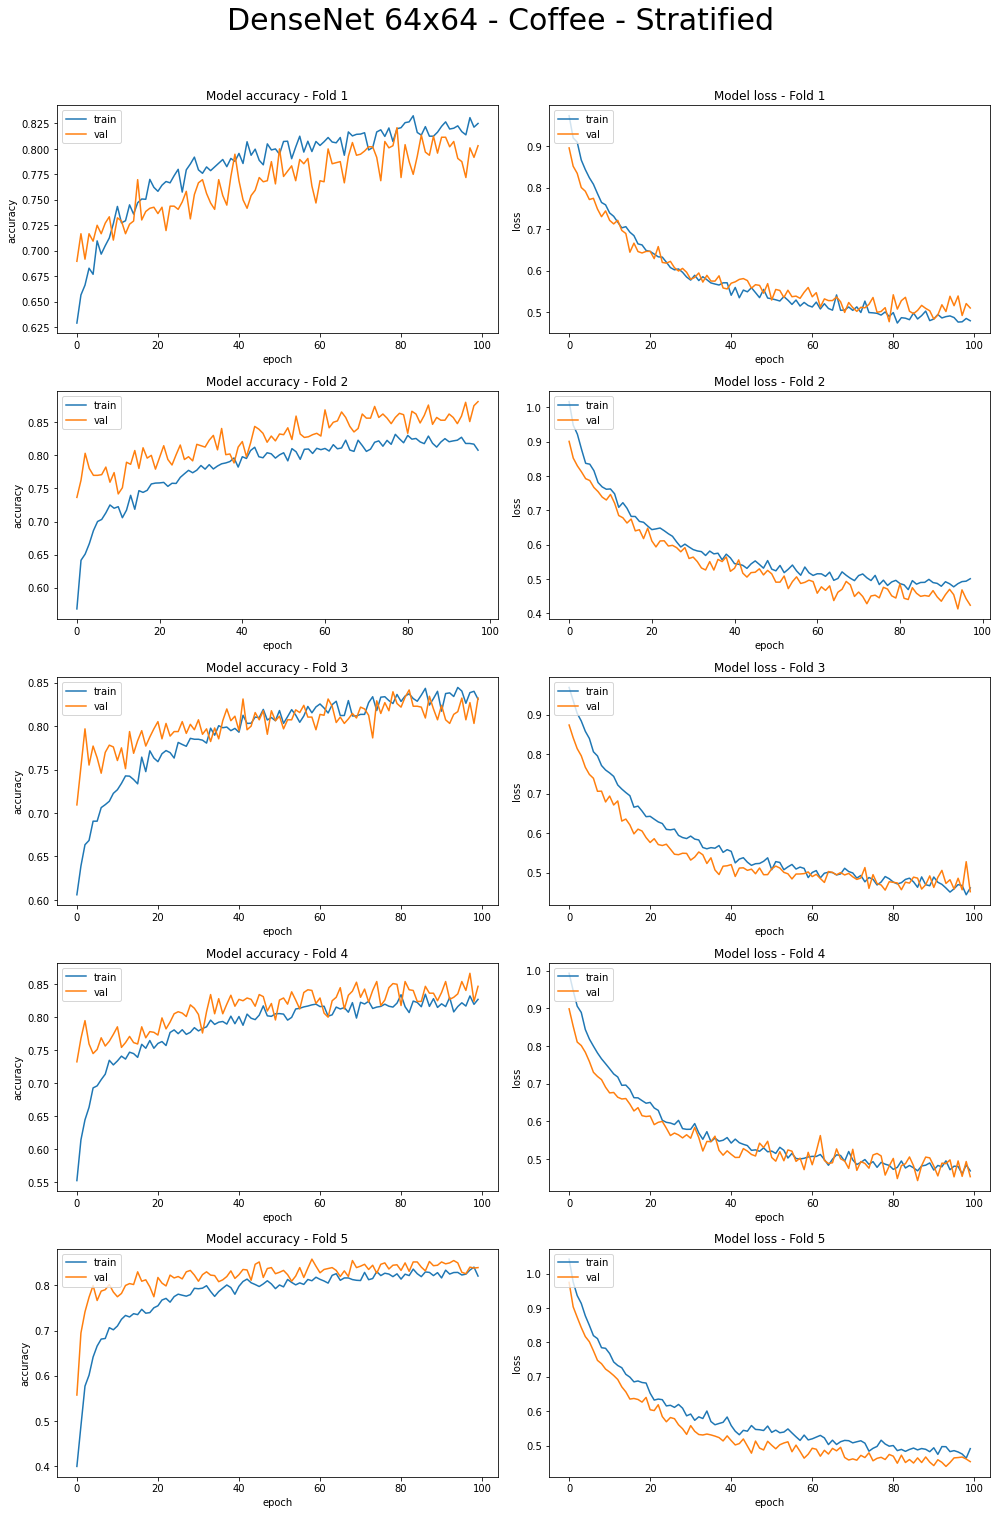

In [6]:
path = os.path.join(SAVED_MODELS_PATH, 'Coffee', 'start_coffee_2')
plot_acc_loss(path, "DenseNet 64x64 - Coffee - Stratified")

# Culture vs no culture

## Spatial - Cross Validation
### Train model

In [9]:
# Params
BATCH_SIZE = 64
EPOCH = 100
LEARNING_RATE = 0.0001
DATA_AUGMENTATION_MULTIPLIATOR = 2
RUN_NAME = 'final_spacv_10FOLD_coffee_1'
NB_FOLD = 5

results= []

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME))

In [10]:
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      f1_score_keras
]

Fold 1 Number culture - train : 752
Fold 1 Number no-culture - train : 566
Fold 1 Number culture - val : 72
Fold 1 Number no-culture - val : 72
Training for fold 1
-----
Epoch 1/100
40/40 [==============================] - 14s 187ms/step - loss: 0.9392 - accuracy: 0.5947 - precision: 0.5209 - recall: 0.5573 - f1_score_keras: 0.5334 - val_loss: 0.5430 - val_accuracy: 0.9531 - val_precision: 1.0000 - val_recall: 0.9091 - val_f1_score_keras: 0.9515
Epoch 2/100
40/40 [==============================] - 5s 130ms/step - loss: 0.7331 - accuracy: 0.7656 - precision: 0.8296 - recall: 0.5995 - f1_score_keras: 0.6907 - val_loss: 0.4156 - val_accuracy: 0.9453 - val_precision: 0.9538 - val_recall: 0.9394 - val_f1_score_keras: 0.9466
Epoch 3/100
40/40 [==============================] - 5s 129ms/step - loss: 0.6046 - accuracy: 0.8218 - precision: 0.8431 - recall: 0.6883 - f1_score_keras: 0.7554 - val_loss: 0.3936 - val_accuracy: 0.9531 - val_precision: 0.9714 - val_recall: 0.9444 - val_f1_score_keras:

Epoch 30/100
40/40 [==============================] - 5s 130ms/step - loss: 0.3336 - accuracy: 0.9129 - precision: 0.9270 - recall: 0.8653 - f1_score_keras: 0.8936 - val_loss: 0.3140 - val_accuracy: 0.8984 - val_precision: 0.8429 - val_recall: 0.9672 - val_f1_score_keras: 0.8981
Epoch 31/100
40/40 [==============================] - 5s 132ms/step - loss: 0.3450 - accuracy: 0.9026 - precision: 0.9066 - recall: 0.8743 - f1_score_keras: 0.8884 - val_loss: 0.3502 - val_accuracy: 0.8828 - val_precision: 0.8824 - val_recall: 0.8955 - val_f1_score_keras: 0.8867
Epoch 32/100
40/40 [==============================] - 5s 130ms/step - loss: 0.3339 - accuracy: 0.9079 - precision: 0.9058 - recall: 0.8723 - f1_score_keras: 0.8863 - val_loss: 0.3557 - val_accuracy: 0.8906 - val_precision: 0.8714 - val_recall: 0.9242 - val_f1_score_keras: 0.8913
Epoch 33/100
40/40 [==============================] - 5s 129ms/step - loss: 0.3516 - accuracy: 0.9075 - precision: 0.9084 - recall: 0.8814 - f1_score_keras: 0.8

40/40 [==============================] - 5s 130ms/step - loss: 0.2640 - accuracy: 0.9409 - precision: 0.9497 - recall: 0.9030 - f1_score_keras: 0.9255 - val_loss: 0.4053 - val_accuracy: 0.8594 - val_precision: 0.8485 - val_recall: 0.8750 - val_f1_score_keras: 0.8619
Epoch 89/100
40/40 [==============================] - 5s 128ms/step - loss: 0.2699 - accuracy: 0.9317 - precision: 0.9402 - recall: 0.8957 - f1_score_keras: 0.9172 - val_loss: 0.3474 - val_accuracy: 0.8906 - val_precision: 0.8857 - val_recall: 0.9118 - val_f1_score_keras: 0.8990
Epoch 90/100
40/40 [==============================] - 5s 130ms/step - loss: 0.2854 - accuracy: 0.9190 - precision: 0.9419 - recall: 0.8622 - f1_score_keras: 0.8990 - val_loss: 0.3199 - val_accuracy: 0.8984 - val_precision: 0.9500 - val_recall: 0.8507 - val_f1_score_keras: 0.9003
Epoch 91/100
40/40 [==============================] - 5s 130ms/step - loss: 0.2564 - accuracy: 0.9313 - precision: 0.9536 - recall: 0.8761 - f1_score_keras: 0.9124 - val_los

Epoch 14/100
38/38 [==============================] - 5s 131ms/step - loss: 0.3850 - accuracy: 0.9051 - precision: 0.9000 - recall: 0.8678 - f1_score_keras: 0.8842 - val_loss: 0.5732 - val_accuracy: 0.7969 - val_precision: 0.8558 - val_recall: 0.7876 - val_f1_score_keras: 0.8186
Epoch 15/100
38/38 [==============================] - 5s 133ms/step - loss: 0.4130 - accuracy: 0.8847 - precision: 0.8710 - recall: 0.8342 - f1_score_keras: 0.8472 - val_loss: 0.4345 - val_accuracy: 0.8594 - val_precision: 0.9245 - val_recall: 0.8376 - val_f1_score_keras: 0.8778
Epoch 16/100
38/38 [==============================] - 5s 131ms/step - loss: 0.3739 - accuracy: 0.9067 - precision: 0.9012 - recall: 0.8769 - f1_score_keras: 0.8886 - val_loss: 0.4211 - val_accuracy: 0.8698 - val_precision: 0.9048 - val_recall: 0.8636 - val_f1_score_keras: 0.8815
Epoch 17/100
38/38 [==============================] - 5s 130ms/step - loss: 0.3729 - accuracy: 0.9039 - precision: 0.8970 - recall: 0.8782 - f1_score_keras: 0.8

Epoch 19/100
36/36 [==============================] - 5s 137ms/step - loss: 0.3745 - accuracy: 0.9012 - precision: 0.9147 - recall: 0.8757 - f1_score_keras: 0.8921 - val_loss: 0.5560 - val_accuracy: 0.8438 - val_precision: 0.5942 - val_recall: 0.7736 - val_f1_score_keras: 0.6725
Epoch 20/100
36/36 [==============================] - 5s 134ms/step - loss: 0.4070 - accuracy: 0.8791 - precision: 0.8852 - recall: 0.8645 - f1_score_keras: 0.8713 - val_loss: 0.4907 - val_accuracy: 0.8438 - val_precision: 0.6324 - val_recall: 0.7414 - val_f1_score_keras: 0.6828
Epoch 21/100
36/36 [==============================] - 5s 134ms/step - loss: 0.3730 - accuracy: 0.8905 - precision: 0.8892 - recall: 0.8854 - f1_score_keras: 0.8853 - val_loss: 0.4651 - val_accuracy: 0.8750 - val_precision: 0.6984 - val_recall: 0.7719 - val_f1_score_keras: 0.7343
Epoch 22/100
36/36 [==============================] - 5s 135ms/step - loss: 0.3527 - accuracy: 0.9035 - precision: 0.9138 - recall: 0.8862 - f1_score_keras: 0.8

Epoch 5/100
32/32 [==============================] - 4s 142ms/step - loss: 0.5072 - accuracy: 0.8569 - precision: 0.8853 - recall: 0.8248 - f1_score_keras: 0.8535 - val_loss: 0.6457 - val_accuracy: 0.7969 - val_precision: 0.7536 - val_recall: 0.4602 - val_f1_score_keras: 0.5580
Epoch 6/100
32/32 [==============================] - 5s 145ms/step - loss: 0.4883 - accuracy: 0.8610 - precision: 0.8899 - recall: 0.8171 - f1_score_keras: 0.8506 - val_loss: 0.6264 - val_accuracy: 0.7969 - val_precision: 0.7121 - val_recall: 0.4434 - val_f1_score_keras: 0.5282
Epoch 7/100
32/32 [==============================] - 5s 145ms/step - loss: 0.4698 - accuracy: 0.8715 - precision: 0.8845 - recall: 0.8645 - f1_score_keras: 0.8731 - val_loss: 0.7370 - val_accuracy: 0.7448 - val_precision: 0.5882 - val_recall: 0.3636 - val_f1_score_keras: 0.4439
Epoch 8/100
32/32 [==============================] - 5s 148ms/step - loss: 0.4471 - accuracy: 0.8772 - precision: 0.8843 - recall: 0.8677 - f1_score_keras: 0.8742 

1/1 [==============================] - 3s 3s/step - loss: 0.7963 - accuracy: 0.7855 - precision: 0.6571 - recall: 0.4259 - f1_score_keras: 0.5169
[[270  23]
 [ 61  47]]
              precision    recall  f1-score   support

           0       0.82      0.92      0.87       293
           1       0.67      0.44      0.53       108

    accuracy                           0.79       401
   macro avg       0.74      0.68      0.70       401
weighted avg       0.78      0.79      0.77       401

F1-Score : 0.5280898876404494


Fold 5 Number culture - train : 668
Fold 5 Number no-culture - train : 382
Fold 5 Number culture - val : 156
Fold 5 Number no-culture - val : 256
Training for fold 5
-----
Epoch 1/100
32/32 [==============================] - 13s 209ms/step - loss: 0.9409 - accuracy: 0.6625 - precision: 0.5060 - recall: 0.5907 - f1_score_keras: 0.5463 - val_loss: 0.9285 - val_accuracy: 0.5417 - val_precision: 1.0000 - val_recall: 0.2787 - val_f1_score_keras: 0.4354
Epoch 2/100
32/32 [=

Epoch 28/100
32/32 [==============================] - 4s 142ms/step - loss: 0.3351 - accuracy: 0.9131 - precision: 0.9265 - recall: 0.8279 - f1_score_keras: 0.8723 - val_loss: 0.6473 - val_accuracy: 0.6797 - val_precision: 0.9612 - val_recall: 0.5124 - val_f1_score_keras: 0.6680
Epoch 29/100
32/32 [==============================] - 4s 144ms/step - loss: 0.3587 - accuracy: 0.9056 - precision: 0.9205 - recall: 0.7951 - f1_score_keras: 0.8483 - val_loss: 0.6180 - val_accuracy: 0.6979 - val_precision: 0.8993 - val_recall: 0.5507 - val_f1_score_keras: 0.6825
Epoch 30/100
32/32 [==============================] - 5s 144ms/step - loss: 0.3232 - accuracy: 0.9222 - precision: 0.9499 - recall: 0.8248 - f1_score_keras: 0.8822 - val_loss: 0.6287 - val_accuracy: 0.6667 - val_precision: 0.8701 - val_recall: 0.5537 - val_f1_score_keras: 0.6745
Epoch 31/100
32/32 [==============================] - 5s 145ms/step - loss: 0.3198 - accuracy: 0.9236 - precision: 0.9311 - recall: 0.8507 - f1_score_keras: 0.8

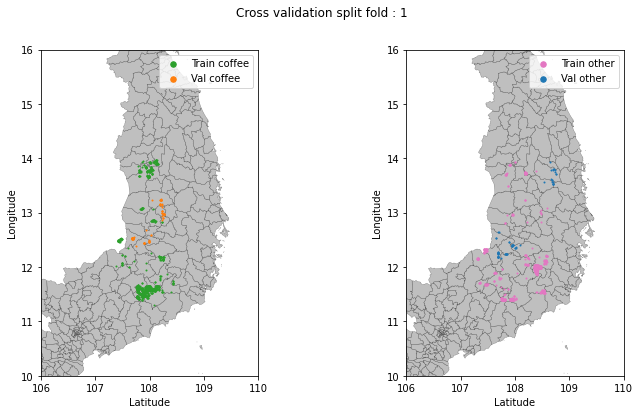

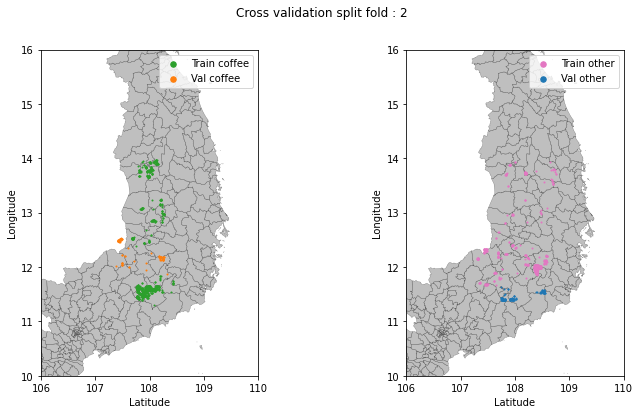

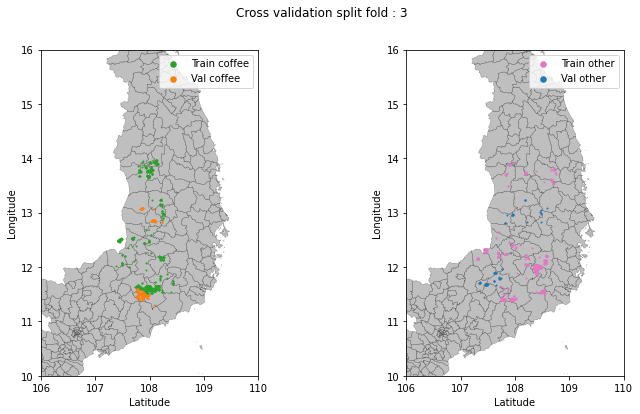

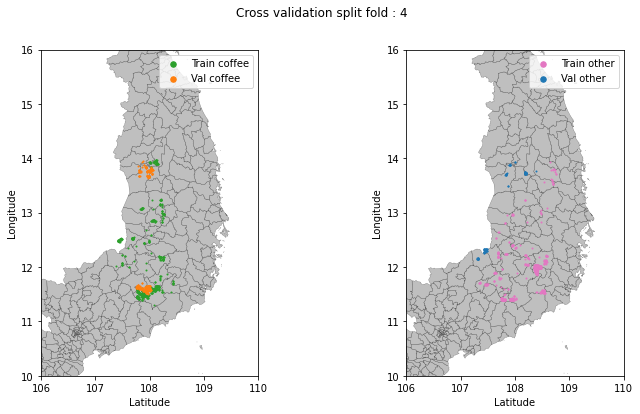

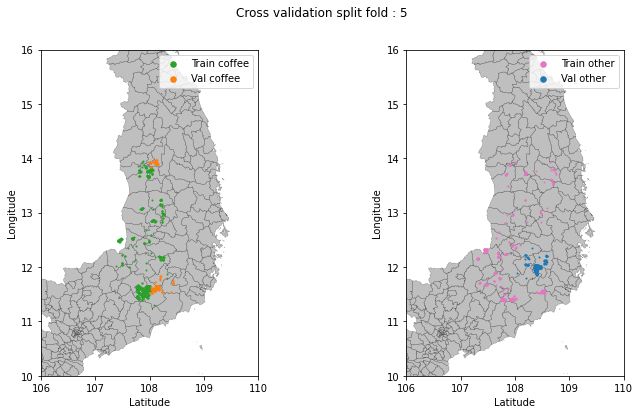

In [14]:
NB_FOLD = 5
for i_fold in range(0, NB_FOLD):
    geo_train = gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","culture_10fold",f"train_{i_fold+1}_data.csv")))
    geo_train['geometry'] = geo_train['geometry'].apply(wkt.loads)
    
    geo_val = gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","culture_10fold",f"val_{i_fold+1}_data.csv")))
    geo_val['geometry'] = geo_val['geometry'].apply(wkt.loads)

    display_cross_val_map_class(geo_train, 
                                geo_val, 
                                vietnam, 
                                f"Cross validation split fold : {i_fold+1}",
                                legend1=["Train culture", "Val culture"],
                                legend2=["Train no-culture", "Val no-culture"])
    
    print(f"Fold {i_fold+1} Number culture - train : {len(geo_train[geo_train['label'] == 0])}")
    print(f"Fold {i_fold+1} Number no-culture - train : {len(geo_train[geo_train['label'] == 1])}")

    print(f"Fold {i_fold+1} Number culture - val : {len(geo_val[geo_val['label'] == 0 ])}")
    print(f"Fold {i_fold+1} Number no-culture - val : {len(geo_val[geo_val['label'] == 1])}")
    print(f"Training for fold {i_fold+1}")

    print("-----")
    
    train_generator = generator(geo_train['path'].to_numpy(), 
                                  geo_train['label'].to_numpy(), 
                                  eurosat_params['mean'], 
                                  eurosat_params['std'], 
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = generator(geo_val['path'].to_numpy(), 
                                geo_val['label'].to_numpy(), 
                                eurosat_params['mean'], 
                                eurosat_params['std'], 
                                batch_size=BATCH_SIZE)


    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
      
    model = create_model()

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)

    history = model.fit(train_generator,
                        epochs=EPOCH,
                        steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=validation_generator,
                        validation_steps=len(geo_val)//BATCH_SIZE,
                        callbacks=[earlystopper])

    model.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '_'+ str(i_fold) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '_'+ str(i_fold) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    results.append(result)

    print(f"Fold {i_fold+1} loss : {result[0]}")
    print(f"Fold {i_fold+1} accuracy : {result[1]}")
    print(f"Fold {i_fold+1} F1-score : {result[4]}")
    
    compute_score(geo_val, model)

    print("\n")

    K.clear_session()

### Fold score

In [15]:
losses, accs, precisions, recalls, f1_score = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")
print("\n")
print(f"Mean f1 : {np.mean(f1_score)}")
print(f"Stdev f1 : {np.std(f1_score)}")

Mean accuracy : 0.815625
Stdev accuracy : 0.07841352970390378


Mean loss : 0.546539843082428
Stdev loss : 0.14764486733318502


Mean precision : 0.7611283302307129
Stdev precision : 0.10856690928662373


Mean recall : 0.7146728038787842
Stdev recall : 0.18588687470253648


Mean f1 : 0.7268824934959411
Stdev f1 : 0.14045134374193116


In [16]:
with open(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

### Loss and accuracy per fold

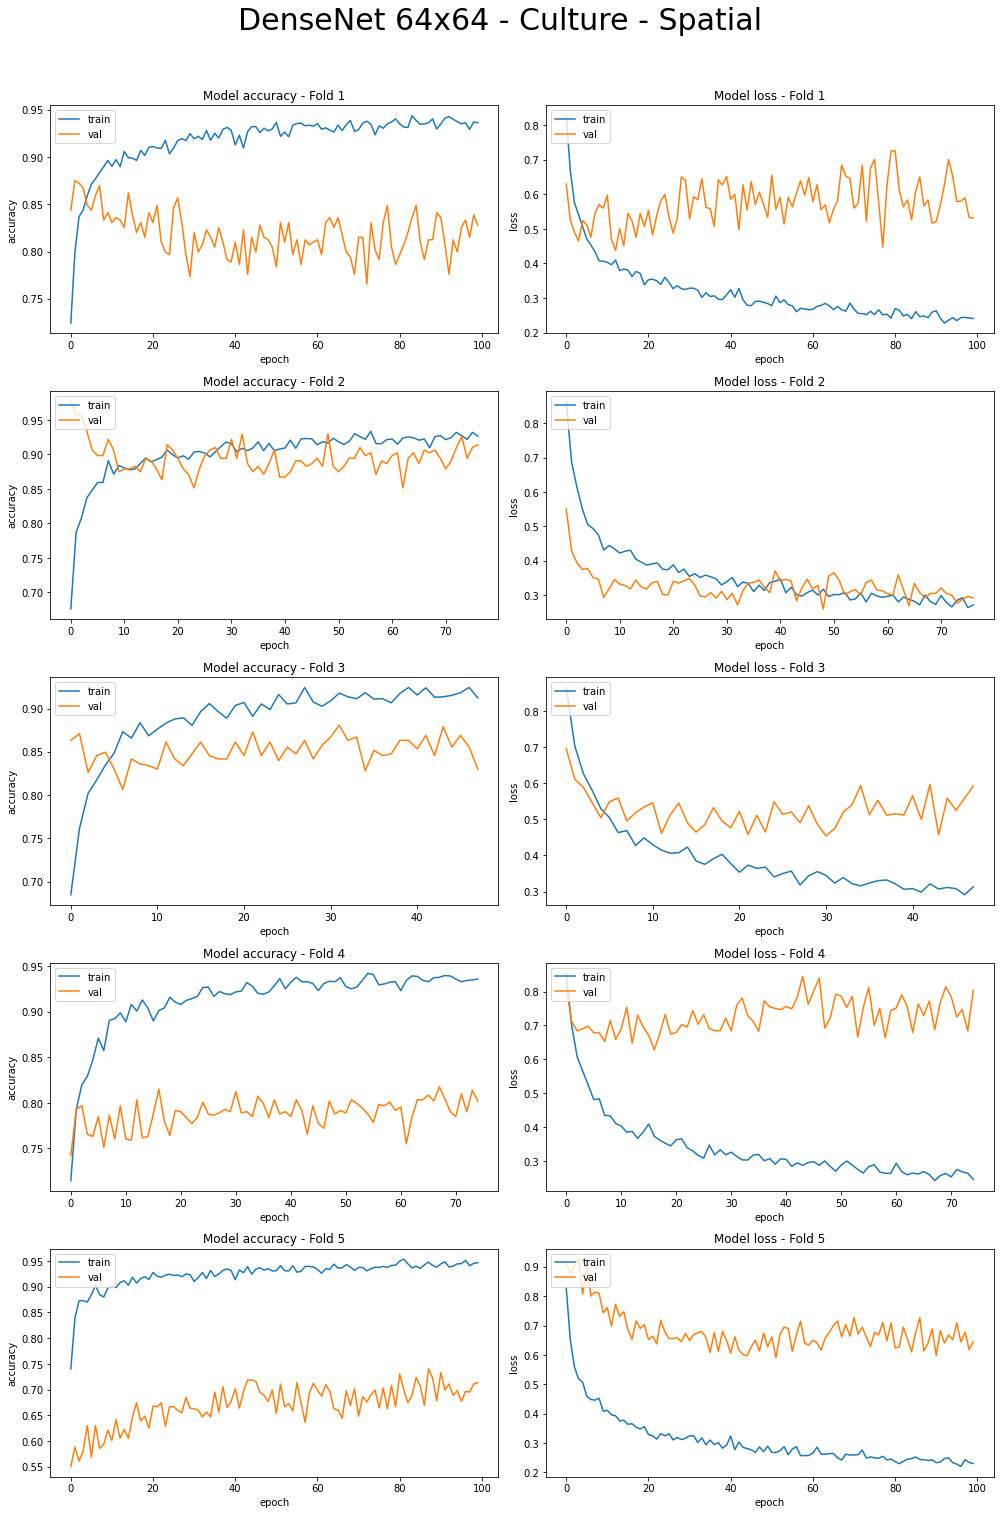

In [7]:
path = os.path.join(SAVED_MODELS_PATH, 'Culture', 'final_spacv_10FOLD_culture_2')
plot_acc_loss(path, "DenseNet 64x64 - Culture - Spatial")

## Stratified cross-val
### Train model

In [11]:
# Params
BATCH_SIZE = 64
EPOCH = 100
LEARNING_RATE = 0.0001
DATA_AUGMENTATION_MULTIPLIATOR = 2
RUN_NAME = 'strat_culture_1'
NB_FOLD = 5

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME))
    
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall')
]

In [12]:
from sklearn.model_selection import StratifiedKFold

fold_index = 0

results = []

skf = StratifiedKFold(n_splits=5)
for train, validation in skf.split(data_train['path'].to_numpy(), data_train['label'].to_numpy()):
    
    geo_train = data_train.iloc[train]
    geo_val = data_train.iloc[validation]
    
    train_generator = generator(geo_train['path'].to_numpy(), 
                                  geo_train['label'].to_numpy(), 
                                  eurosat_params['mean'], 
                                  eurosat_params['std'], 
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = generator(geo_val['path'].to_numpy(), 
                                geo_val['label'].to_numpy(), 
                                eurosat_params['mean'], 
                                eurosat_params['std'], 
                                batch_size=BATCH_SIZE)


    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
      
    model = create_model()

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)

    history = model.fit(train_generator,
                                epochs=EPOCH,
                                steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                                validation_data=validation_generator,
                                validation_steps=len(geo_val)//BATCH_SIZE,
                                callbacks=[earlystopper])

    model.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    result.append(2*((result[2]*result[3])/(result[2]+result[3])))
    results.append(result)
    
    print(f"Fold {fold_index} loss : {result[0]}")
    print(f"Fold {fold_index} accuracy : {result[1]}")
    print(f"Fold {fold_index} F1-score : {result[4]}")
    print("\n")

    K.clear_session()

    fold_index+=1

Epoch 1/100
36/36 [==============================] - 15s 207ms/step - loss: 0.9168 - accuracy: 0.6147 - precision: 0.5715 - recall: 0.7572 - val_loss: 0.6544 - val_accuracy: 0.8438 - val_precision: 0.9822 - val_recall: 0.6831
Epoch 2/100
36/36 [==============================] - 5s 140ms/step - loss: 0.6750 - accuracy: 0.8042 - precision: 0.8781 - recall: 0.6799 - val_loss: 0.5700 - val_accuracy: 0.8457 - val_precision: 0.9465 - val_recall: 0.7195
Epoch 3/100
36/36 [==============================] - 5s 139ms/step - loss: 0.5826 - accuracy: 0.8253 - precision: 0.8821 - recall: 0.7337 - val_loss: 0.5317 - val_accuracy: 0.8496 - val_precision: 0.9583 - val_recall: 0.6970
Epoch 4/100
36/36 [==============================] - 5s 137ms/step - loss: 0.5304 - accuracy: 0.8463 - precision: 0.9062 - recall: 0.7449 - val_loss: 0.4913 - val_accuracy: 0.8691 - val_precision: 0.9561 - val_recall: 0.7717
Epoch 5/100
36/36 [==============================] - 5s 140ms/step - loss: 0.4935 - accuracy: 0.862

36/36 [==============================] - 5s 145ms/step - loss: 0.4696 - accuracy: 0.8465 - precision: 0.8708 - recall: 0.7777 - val_loss: 0.3863 - val_accuracy: 0.8984 - val_precision: 0.9670 - val_recall: 0.8200
Epoch 10/100
36/36 [==============================] - 5s 143ms/step - loss: 0.4299 - accuracy: 0.8675 - precision: 0.9011 - recall: 0.8073 - val_loss: 0.4216 - val_accuracy: 0.8945 - val_precision: 0.9548 - val_recall: 0.7860
Epoch 11/100
36/36 [==============================] - 5s 146ms/step - loss: 0.3934 - accuracy: 0.8938 - precision: 0.9317 - recall: 0.8421 - val_loss: 0.3964 - val_accuracy: 0.8926 - val_precision: 0.9431 - val_recall: 0.8223
Epoch 12/100
36/36 [==============================] - 5s 142ms/step - loss: 0.4338 - accuracy: 0.8701 - precision: 0.8883 - recall: 0.8266 - val_loss: 0.4186 - val_accuracy: 0.8691 - val_precision: 0.9190 - val_recall: 0.7942
Epoch 13/100
36/36 [==============================] - 5s 143ms/step - loss: 0.4366 - accuracy: 0.8766 - preci

36/36 [==============================] - 5s 141ms/step - loss: 0.2772 - accuracy: 0.9272 - precision: 0.9426 - recall: 0.8938 - val_loss: 0.2687 - val_accuracy: 0.9297 - val_precision: 0.9649 - val_recall: 0.8871
Epoch 82/100
36/36 [==============================] - 5s 142ms/step - loss: 0.2630 - accuracy: 0.9224 - precision: 0.9299 - recall: 0.9022 - val_loss: 0.2906 - val_accuracy: 0.9199 - val_precision: 0.9415 - val_recall: 0.8694
Epoch 83/100
36/36 [==============================] - 5s 140ms/step - loss: 0.2618 - accuracy: 0.9316 - precision: 0.9520 - recall: 0.9079 - val_loss: 0.3157 - val_accuracy: 0.9043 - val_precision: 0.9283 - val_recall: 0.8625
Epoch 84/100
36/36 [==============================] - 5s 139ms/step - loss: 0.2722 - accuracy: 0.9262 - precision: 0.9384 - recall: 0.9003 - val_loss: 0.2677 - val_accuracy: 0.9277 - val_precision: 0.9469 - val_recall: 0.9062
Epoch 85/100
36/36 [==============================] - 5s 141ms/step - loss: 0.2490 - accuracy: 0.9340 - preci

36/36 [==============================] - 5s 139ms/step - loss: 0.2902 - accuracy: 0.9174 - precision: 0.9157 - recall: 0.9158 - val_loss: 0.2822 - val_accuracy: 0.9277 - val_precision: 0.9358 - val_recall: 0.8987
Epoch 53/100
36/36 [==============================] - 5s 139ms/step - loss: 0.2853 - accuracy: 0.9309 - precision: 0.9493 - recall: 0.9072 - val_loss: 0.2892 - val_accuracy: 0.9336 - val_precision: 0.9824 - val_recall: 0.8814
Epoch 54/100
36/36 [==============================] - 5s 139ms/step - loss: 0.2851 - accuracy: 0.9288 - precision: 0.9475 - recall: 0.9018 - val_loss: 0.2688 - val_accuracy: 0.9277 - val_precision: 0.9309 - val_recall: 0.9197
Epoch 55/100
36/36 [==============================] - 5s 140ms/step - loss: 0.3079 - accuracy: 0.9168 - precision: 0.9252 - recall: 0.8992 - val_loss: 0.2868 - val_accuracy: 0.9297 - val_precision: 0.9532 - val_recall: 0.8996
Epoch 56/100
36/36 [==============================] - 5s 140ms/step - loss: 0.2937 - accuracy: 0.9213 - preci

36/36 [==============================] - 5s 138ms/step - loss: 0.3123 - accuracy: 0.9228 - precision: 0.9366 - recall: 0.8917 - val_loss: 0.2884 - val_accuracy: 0.9238 - val_precision: 0.8920 - val_recall: 0.9489
Epoch 40/100
36/36 [==============================] - 5s 139ms/step - loss: 0.3126 - accuracy: 0.9136 - precision: 0.9186 - recall: 0.8893 - val_loss: 0.2844 - val_accuracy: 0.9238 - val_precision: 0.9053 - val_recall: 0.9322
Epoch 41/100
36/36 [==============================] - 5s 138ms/step - loss: 0.3312 - accuracy: 0.9072 - precision: 0.9126 - recall: 0.8715 - val_loss: 0.2957 - val_accuracy: 0.9043 - val_precision: 0.8806 - val_recall: 0.9328
Epoch 42/100
36/36 [==============================] - 5s 138ms/step - loss: 0.3357 - accuracy: 0.9020 - precision: 0.9160 - recall: 0.8737 - val_loss: 0.2965 - val_accuracy: 0.9121 - val_precision: 0.8953 - val_recall: 0.9277
Epoch 43/100
36/36 [==============================] - 5s 140ms/step - loss: 0.2912 - accuracy: 0.9337 - preci

36/36 [==============================] - 5s 139ms/step - loss: 0.3460 - accuracy: 0.9218 - precision: 0.9294 - recall: 0.9004 - val_loss: 0.3943 - val_accuracy: 0.8789 - val_precision: 0.8565 - val_recall: 0.8788
Epoch 20/100
36/36 [==============================] - 5s 139ms/step - loss: 0.3682 - accuracy: 0.9040 - precision: 0.9216 - recall: 0.8721 - val_loss: 0.3818 - val_accuracy: 0.8945 - val_precision: 0.9087 - val_recall: 0.8438
Epoch 21/100
36/36 [==============================] - 5s 136ms/step - loss: 0.3671 - accuracy: 0.9006 - precision: 0.9316 - recall: 0.8526 - val_loss: 0.4088 - val_accuracy: 0.8633 - val_precision: 0.8805 - val_recall: 0.8223
Epoch 22/100
36/36 [==============================] - 5s 138ms/step - loss: 0.3573 - accuracy: 0.8968 - precision: 0.9062 - recall: 0.8724 - val_loss: 0.3579 - val_accuracy: 0.9043 - val_precision: 0.9321 - val_recall: 0.8583
Epoch 23/100
36/36 [==============================] - 5s 140ms/step - loss: 0.3321 - accuracy: 0.9195 - preci

36/36 [==============================] - 5s 137ms/step - loss: 0.2469 - accuracy: 0.9387 - precision: 0.9700 - recall: 0.8974 - val_loss: 0.2920 - val_accuracy: 0.9277 - val_precision: 0.9378 - val_recall: 0.9113
Epoch 92/100
36/36 [==============================] - 5s 137ms/step - loss: 0.2522 - accuracy: 0.9351 - precision: 0.9540 - recall: 0.9085 - val_loss: 0.2703 - val_accuracy: 0.9414 - val_precision: 0.9651 - val_recall: 0.9095
Epoch 93/100
36/36 [==============================] - 5s 137ms/step - loss: 0.2580 - accuracy: 0.9243 - precision: 0.9408 - recall: 0.8981 - val_loss: 0.2701 - val_accuracy: 0.9277 - val_precision: 0.9414 - val_recall: 0.9073
Epoch 94/100
36/36 [==============================] - 5s 137ms/step - loss: 0.2492 - accuracy: 0.9342 - precision: 0.9467 - recall: 0.9144 - val_loss: 0.3196 - val_accuracy: 0.9180 - val_precision: 0.9518 - val_recall: 0.8750
Epoch 95/100
36/36 [==============================] - 5s 135ms/step - loss: 0.2556 - accuracy: 0.9324 - preci

### Fold scores

In [17]:
losses, accs, precisions, recalls, f1_scores = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")
print("\n")
print(f"Mean F1-Score : {np.mean(f1_scores)}")
print(f"Stdev F1-Score : {np.std(f1_scores)}")

Mean accuracy : 0.85859375
Stdev accuracy : 0.009043622580304864


Mean loss : 0.41293240189552305
Stdev loss : 0.027867288674426484


Mean precision : 0.8757479310035705
Stdev precision : 0.005627822229397637


Mean recall : 0.9458356380462647
Stdev recall : 0.012983210322106366


Mean F1-Score : 0.909388249922852
Stdev F1-Score : 0.006541125551406981


In [ ]:
with open(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

### Loss and accuracy per fold

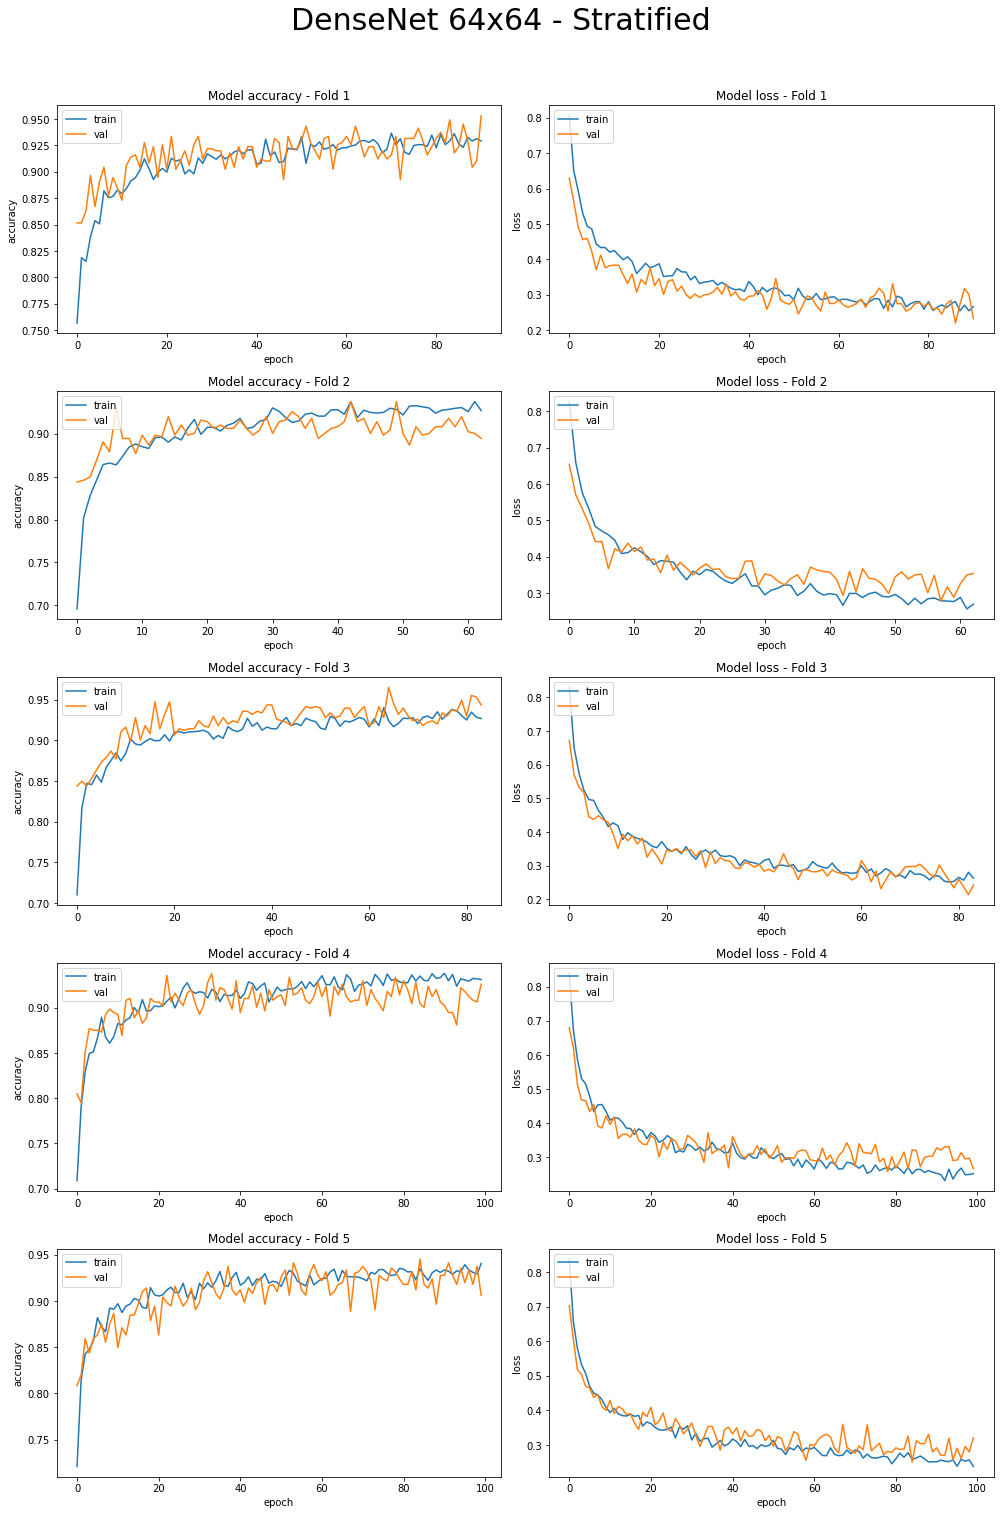

In [8]:
path = os.path.join(SAVED_MODELS_PATH, 'Culture', 'strat_culture_1')
plot_acc_loss(path, "DenseNet 64x64 - Stratified")